In [4]:
import xarray as xr
import rioxarray as rioxr

import geopandas as geopd
import pandas as pd

import numpy as np

import os
from multiprocessing import Pool

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

In [3]:
vector_watershed_path = "/home/iiro/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_catchments.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='v1')

<Axes: >

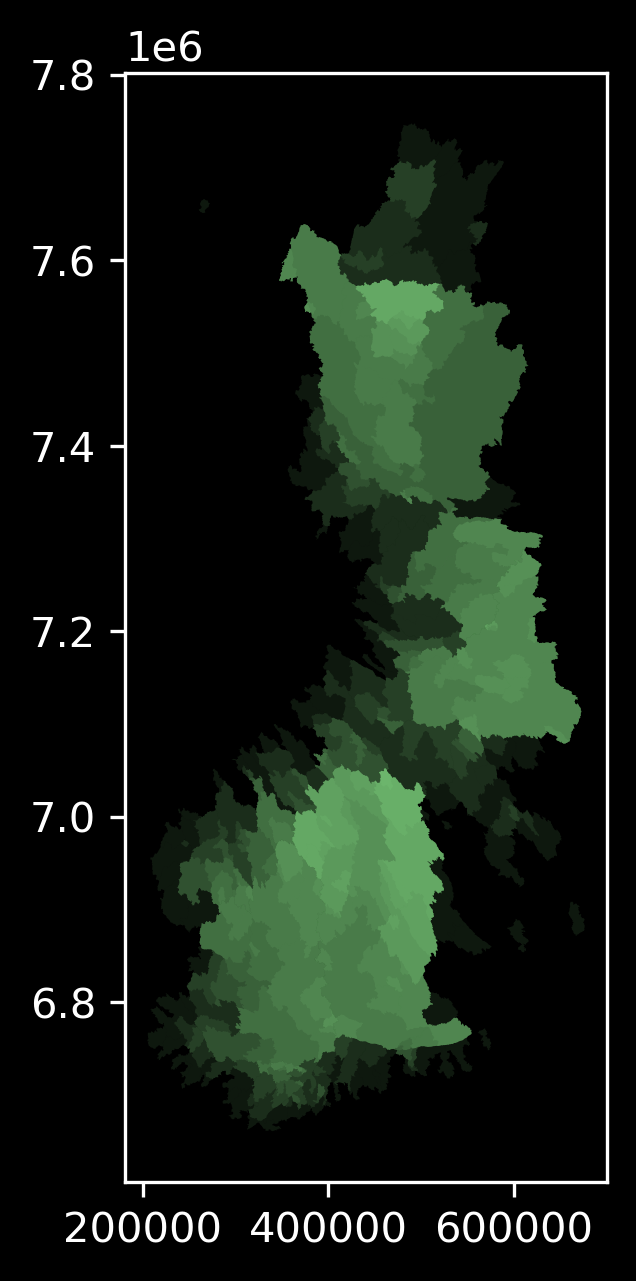

In [6]:
ax = watersheds.plot(alpha=0.1, color='lightgreen')

In [4]:
# Special case for processing Aurajoki separately for Bea
#watersheds = watersheds[watersheds['Paikka_Id'] == '1117'].reset_index(drop=True)

In [10]:
def catchment_mean(args):
    data_array, watershed, time = args
    one_day_data = data_array.sel({'Time':time})

    # Calculating the average of the attribute for the whole catchment
    clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs)
    average = clipped.mean().item()
    average = round(average, 2)
    # Failsafe for catchments smaller than the pixel size
    if average is np.nan:
        clipped = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True)
        average = clipped.mean().item()
        

    return average

In [ ]:
root = "/media/iiro/T9/finland_climate/fmi_grid_download"

dirs = ['RRday', 'ET0_FAO', 'Tday',
        'Tgmin', 'Tmin', 'Tmax',
        'Rh', 'Globrad', 'Snow']
# Converting from FMI namespace to CAMELS
attributes = {'Rh' : 'humidity' ,'ET0_FAO': 'pet', 'Tday': 'temperature_mean',
              'Tmin': 'temperature_min', 'Tgmin': 'temperature_gmin', 'Tmax': 'temperature_max',
              'RRday': 'precipitation', 'Globrad': 'radiation_global', 'Snow': 'snow_depth'}
dst_dir = "/media/iiro/T9/CAMELS-FI/data/timeseries"

if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

years = (1961, 2023)

weather = pd.DataFrame(index=pd.to_datetime([]))
weather.index.name = 'date'
pbar = tqdm(range(len(watersheds)))
for i in pbar:
    watershed = watersheds.loc[[i]]
    place_id = watershed.at[i, 'Paikka_Id']
    # Constructing the path of the timeseries for this catchmentparallel 
    path = os.path.join(dst_dir, f"CAMELS_FI_hydromet_timeseries_{place_id}_{years[0]}0101-{years[1]}1231.csv")
    for current_dir in dirs:
         
        for year in range(years[0], years[1] + 1):
            pbar.set_description(f"Processing watershed {place_id:>4}, {attributes[current_dir]:>16}, {year}")
            # Evapotranspiration has differing scheme to all other sources
            if current_dir == 'ET0_FAO':
                # Different time range than other variables
                file_name = f"{current_dir}_{year}_months_4_to_9.nc"
            else:
                file_name = f"{current_dir.lower()}_{year}.nc"
            src_path = os.path.join(root, current_dir, file_name)
            
            if not os.path.exists(src_path):
                print(f"path {src_path} doesn't exists")
                continue
            
            with rioxr.open_rasterio(src_path, mask_and_scale=True) as src:
                data_array = src.copy()
    
            # Iterating over the days and adding it to a list for parallel mapping
            arg_list = []
            times = []
            for time_step in data_array.Time:
                time = time_step.item()
                
                arg_list.append((data_array, watershed, time))
                # turning cftime to str helps pandas parse it as datetime index
                times.append(str(time))
            
            with Pool(6) as p:
                averages = p.map(catchment_mean, arg_list)
            
            # Saving the results 
            for average, time in list(zip(averages, times)):
                weather.loc[time,  attributes[current_dir]] = average
            
                

    weather.to_csv(path)
                
            
        

    

  0%|          | 0/334 [00:00<?, ?it/s]

path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1961_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1962_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1963_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1964_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1965_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1966_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1967_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1968_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/fmi_grid_download/ET0_FAO/ET0_FAO_1969_months_4_to_9.nc doesn't exists
path /media/iiro/T9/finland_climate/f

1.7423689365386963


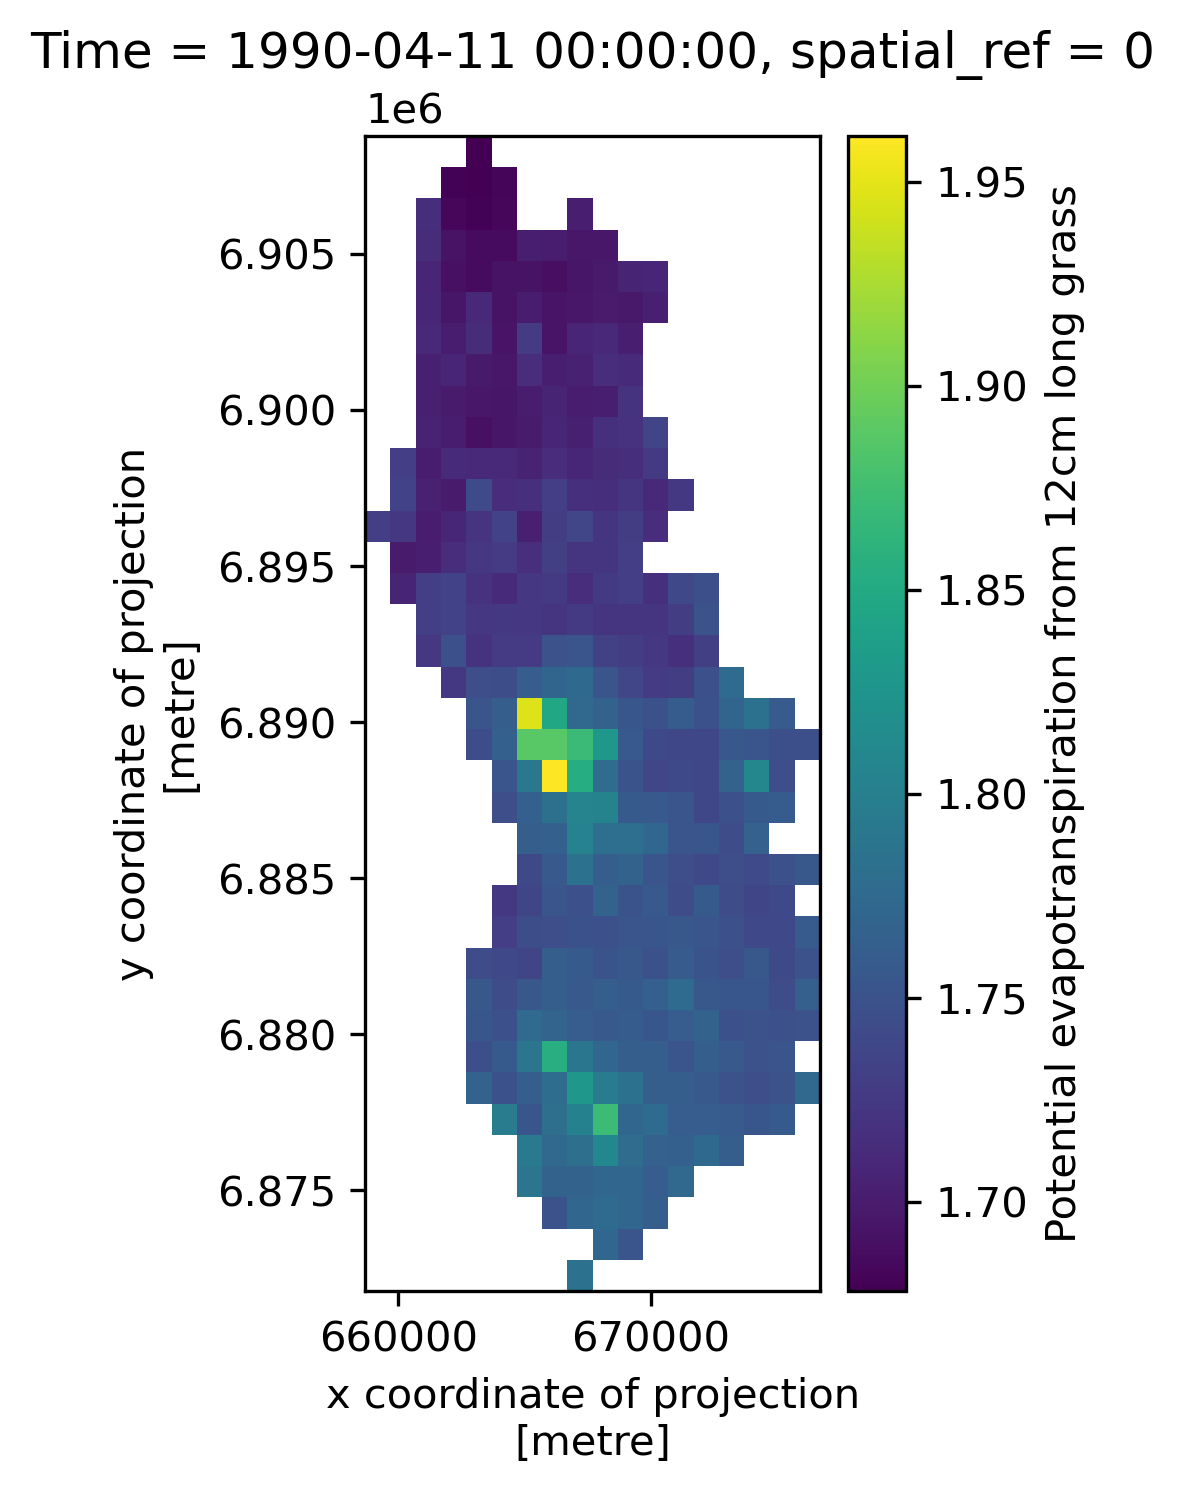

In [10]:
bounds = watershed.bounds
minx = bounds.at[i, 'minx']
maxx = bounds.at[i, 'maxx']
miny = bounds.at[i, 'miny']
maxy = bounds.at[i, 'maxy']
aspect = (maxx-minx) / (maxy-miny)
print(one_day_data.rio.clip(watershed.geometry.values).mean().item())
qm = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs).plot(aspect=aspect, size=5, cbar_kwargs={'label': one_day_data.long_name})

In [16]:
dirs = ['RRday', 'ET0_FAO', 'Tday',
        'Tgmin', 'Tmin', 'Tmax',
        'Rh', 'Globrad']
# Converting from FMI namespace to CAMELS
attributes = {'Rh' : 'humidity' ,'ET0_FAO': 'pet', 'Tday': 'temperature_mean',
              'Tmin': 'temperature_min', 'Tgmin': 'temperature_gmin', 'Tmax': 'temperature_max',
              'RRday': 'precipitation', 'Globrad': 'radiation_global'}

weather_test = pd.DataFrame(index=pd.to_datetime([]))
time_list = ["2020-01-01", "2020-01-02"]
attributes = [1,2]
for attribute, time in list(zip(attributes, time_list)):
    weather_test.loc[time,  'attribute'] = attribute
weather_test

,attribute
2020-01-01,1.0
2020-01-02,2.0


,attribute_1,attribute_2
2020-01-02,NaN,1


In [6]:
data_array.dims

('Time', 'y', 'x')

In [97]:
weather = pd.DataFrame(columns=['date'] + dirs, index=pd.to_datetime([]))

In [107]:
weather.loc[str(time), 'ET0_FAO'] = 1

In [112]:
pd.to_datetime(str(time)).date()

datetime.date(1994, 4, 1)

In [106]:
pd.to_datetime(str(time))

Timestamp('1994-04-01 00:00:00')

In [8]:
for time_step in data_array.Time:
    time = time_step.item()
    
    break

In [9]:
#one_day_data = data_array.sel({'Time':'1994-04-01'})
one_day_data = data_array.sel({'Time':time})
#one_day_data.write_nodata(np.nan, inplace=True)


In [91]:
clipped = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs)

0.9074239730834961


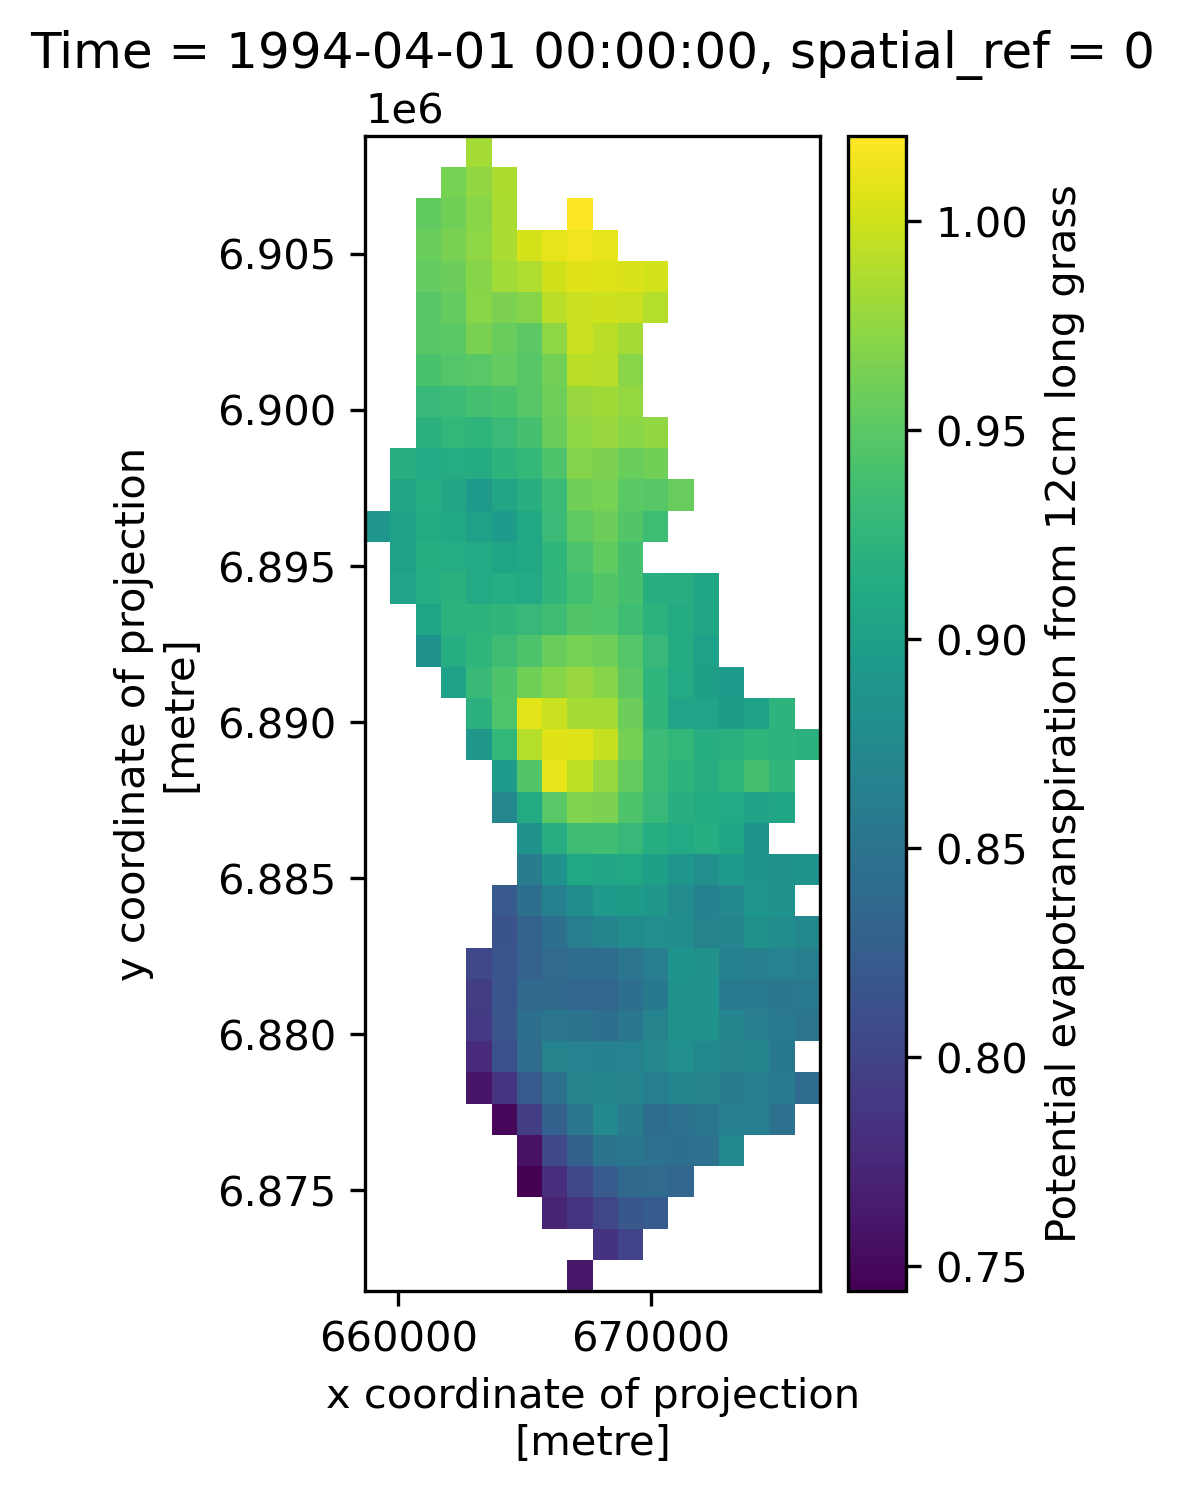

In [90]:
"""
geometries = [
    {
        'type':'Polygon',
        'coordinates': [[
            [300_000, 6_800_000],
            [400_000, 6_800_000],
            [400_000, 7_000_000],
            [350_000, 6_900_000],
            [300_000, 7_000_000]
        ]]
    }
]
"""
i = 0
watershed = watersheds.loc[[i]] 
bounds = watershed.bounds
minx = bounds.at[i, 'minx']
maxx = bounds.at[i, 'maxx']
miny = bounds.at[i, 'miny']
maxy = bounds.at[i, 'maxy']
aspect = (maxx-minx) / (maxy-miny)
print(one_day_data.rio.clip(watershed.geometry.values).mean().item())
qm = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs).plot(aspect=aspect, size=5, cbar_kwargs={'label': one_day_data.long_name})

In [69]:
one_day_data.long_name

'Potential evapotranspiration from 12cm long grass'

<Axes: >

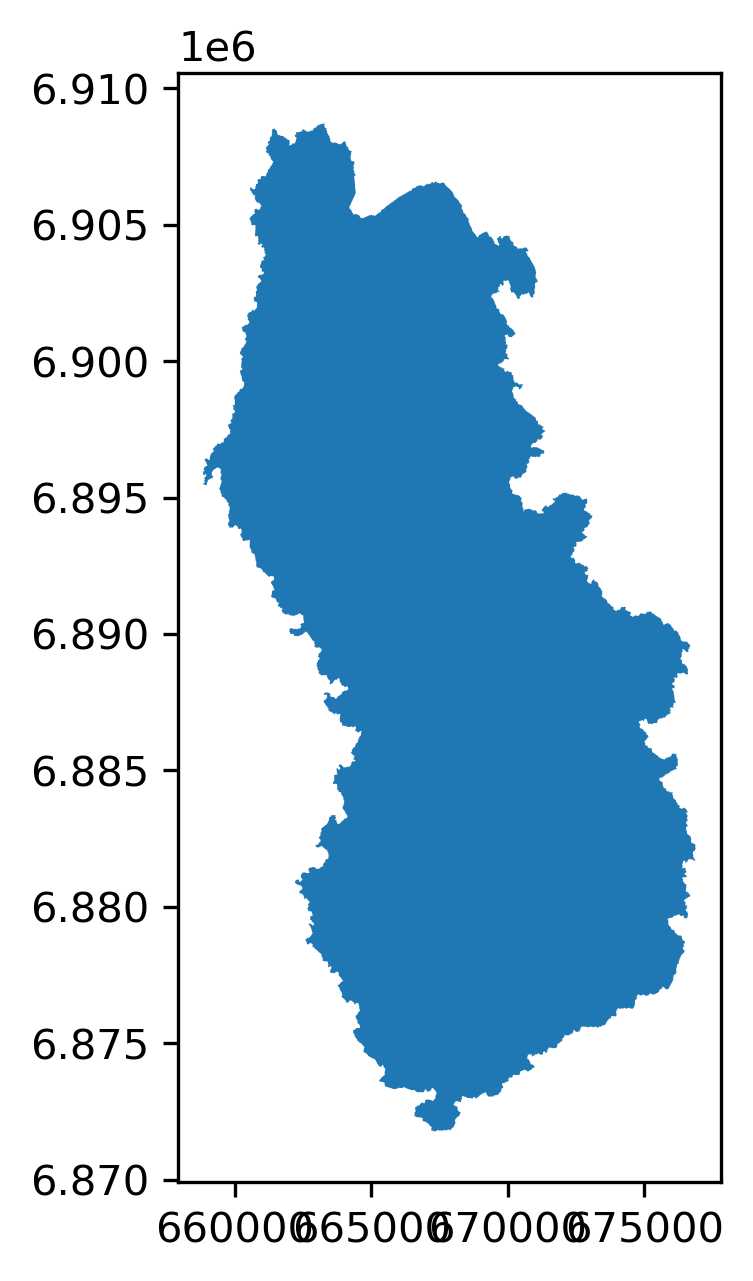

In [89]:
watershed.plot()

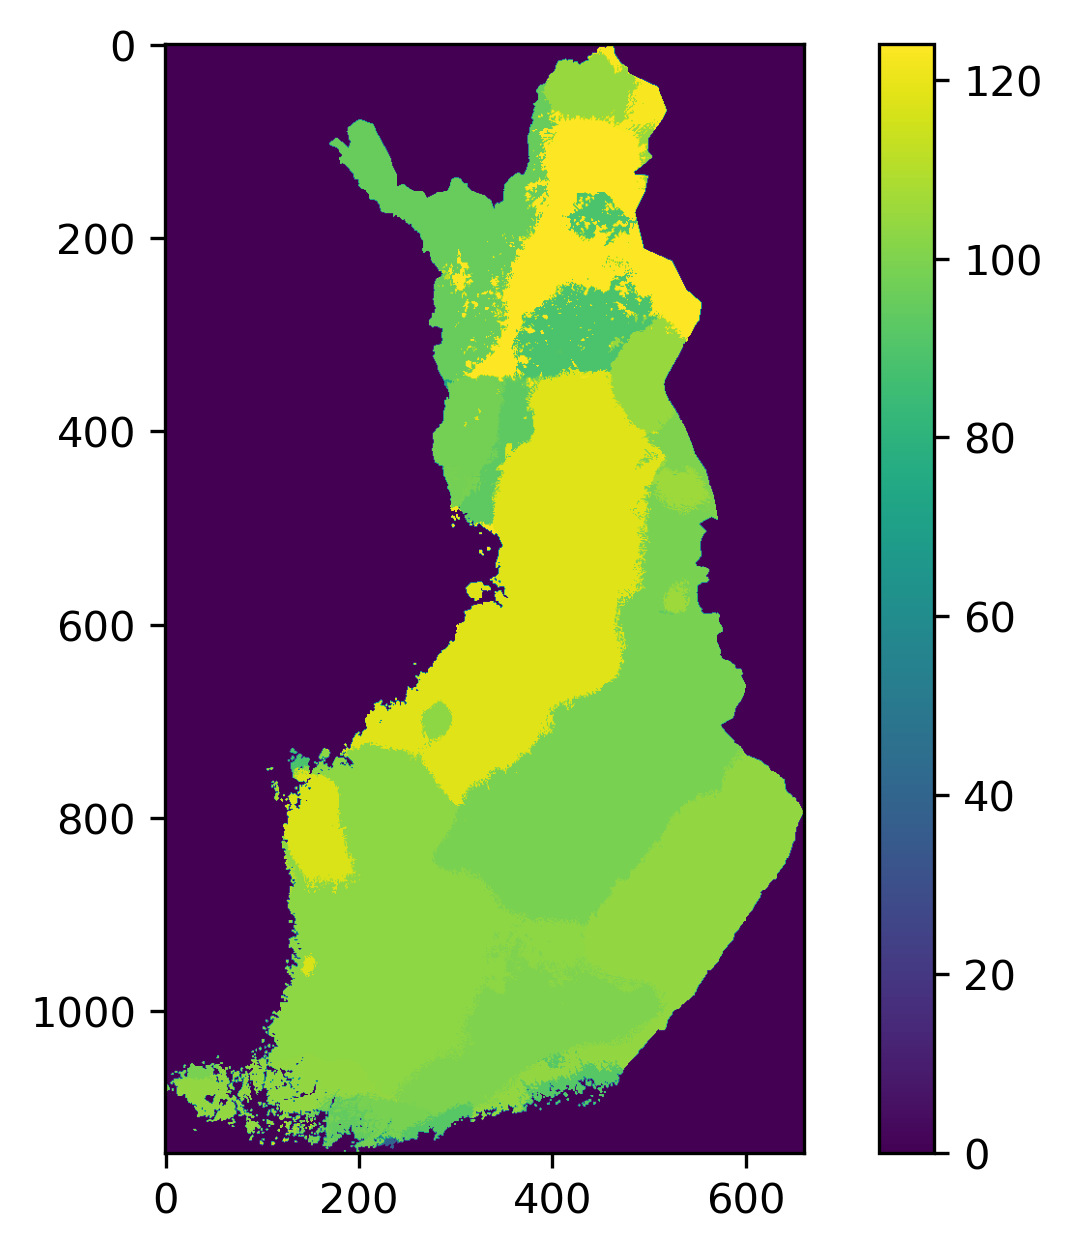

In [36]:
im = plt.imshow(data_array.argmax('Time'))
cbar = plt.colorbar(im)

In [59]:
print(data_array.x.to_numpy().min(), data_array.x.to_numpy().max())

73189.8723 733189.8723
